# 1. Define binning and model

In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from optbinning import MulticlassOptimalBinning

import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

Welcome to JupyROOT 6.26/14


In [2]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.4
end = 4.8
num_bins = 50

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -2.5
end = 10
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)


# Check for empty bins
# empty_bins = [41, 42, 43, 44, 46, 47, 48, 49]

# Merge adjacent empty bins
# merged_bins = np.delete(bins, empty_bins)

# Define relevant variables
training_variables = util.training_variables

In [3]:
## Loading Ntuples
columns = util.all_relevant_variables

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1)'

# Load data files
e_generic = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/MC15ri_1ab_quaxo_e_2/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

e_sig = uproot.concatenate([f'../Samples/Generic_MC15ri/e_channel/MC15ri_sig_quaxo_e_1/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

In [57]:
df_e_generic = pd.DataFrame(e_generic).sample(frac=1).reset_index(drop=True)
df_e_sig = pd.DataFrame(e_sig)

lgb_tight = 'sig_prob==largest_prob and sig_prob>0.65 and fakeD_prob<0.05'

for df in [df_e_generic,df_e_sig]:
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

df_e_generic_lgb = util.apply_mva_bcs(df_e_generic, training_variables, lgb_tight, library='lgbm')
df_e_sig_lgb = util.apply_mva_bcs(df_e_sig, training_variables, lgb_tight, library='lgbm')



# mu_temp = uproot.concatenate([f'../Samples/Generic_MC15ri/mu_channel/MC15ri_local_200fb/*.root:B0'],
#                           library="np",
#                           #cut=input_cut,
#                           filter_branch=lambda branch: branch.name in columns)

# df_mu = pd.DataFrame(mu_temp)
# df_mu['__weight__'] = 5

# df_mu.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
# df_mu.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [58]:
t_e_generic = util.classify_mc_dict(df_e_generic_lgb, 'e', template=False)
t_e_sig = util.classify_mc_dict(df_e_sig_lgb, 'e', template=False)

for name, df in t_e_generic.items():
    if name == 'bkg_fakeD':
        df = df.query('1.855<D_M<1.885')
        t_e_generic[name]=df
    print(name, len(df))

bkg_fakeD 15757
bkg_TDFl 6338
bkg_fakeTracks 2637
bkg_continuum 13203
bkg_combinatorial 15124
bkg_singleBbkg 9611
bkg_other_TDTl 0
$D\tau\nu$ 4241
$D^\ast\tau\nu$ 2483
$D\ell\nu$ 90282
$D^\ast\ell\nu$ 57810
$D^{\ast\ast}\tau\nu$ 1472
$D^{\ast\ast}\ell\nu$_narrow 18373
$D^{\ast\ast}\ell\nu$_broad 14110
$D\ell\nu$_gap_pi 3467
$D\ell\nu$_gap_eta 3076
bkg_other_signal 0


In [6]:
# use signal MC
for name, df in t_e_sig.items():
    print(name, len(df))

bkg_fakeD 20347
bkg_TDFl 1805
bkg_fakeTracks 1350
bkg_continuum 0
bkg_combinatorial 11586
bkg_singleBbkg 2492
bkg_other_TDTl 0
$D\tau\nu$ 18671
$D^\ast\tau\nu$ 9709
$D\ell\nu$ 30176
$D^\ast\ell\nu$ 19336
$D^{\ast\ast}\tau\nu$ 17312
$D^{\ast\ast}\ell\nu$_narrow 5671
$D^{\ast\ast}\ell\nu$_broad 3937
$D\ell\nu$_gap_pi 1184
$D\ell\nu$_gap_eta 1335
bkg_other_signal 0


In [7]:
sig_comp = [r'$D\tau\nu$', r'$D^\ast\tau\nu$', r'$D^{\ast\ast}\tau\nu$']
te = {k:v for k,v in t_e_generic.items() if k not in sig_comp}
for c_name in sig_comp:
    te[c_name] = t_e_sig[c_name]
    
for name, df in te.items():
    print(name, len(df))

bkg_fakeD 6458
bkg_TDFl 2559
bkg_fakeTracks 1122
bkg_continuum 5279
bkg_combinatorial 6044
bkg_singleBbkg 3833
bkg_other_TDTl 0
$D\ell\nu$ 36170
$D^\ast\ell\nu$ 23174
$D^{\ast\ast}\ell\nu$_narrow 7190
$D^{\ast\ast}\ell\nu$_broad 5693
$D\ell\nu$_gap_pi 1413
$D\ell\nu$_gap_eta 1214
bkg_other_signal 0
$D\tau\nu$ 18671
$D^\ast\tau\nu$ 9709
$D^{\ast\ast}\tau\nu$ 17312


In [59]:
samples_for_optbinning = {
#                           'bkg':[t_e_generic['bkg_fakeD'].sample(n=1000),
#                                  t_e_generic['bkg_TDFl'].sample(n=1000),
#                                  t_e_generic['bkg_continuum'].sample(n=4000),
#                                  t_e_generic['bkg_combinatorial'].sample(n=4000),
#                                  t_e_generic['bkg_singleBbkg'].sample(n=1000),
#                                 ],
#                           r'$D\ell\nu$': t_e_generic[r'$D\ell\nu$'].sample(n=20000),
#                           r'$D^\ast\ell\nu$': t_e_generic[r'$D^\ast\ell\nu$'].sample(n=20000),
                          r'$D^{\ast\ast}\ell\nu$': [t_e_generic[r'$D^{\ast\ast}\ell\nu$_narrow'].sample(n=2000),
                                                     t_e_generic[r'$D^{\ast\ast}\ell\nu$_broad'].sample(n=2000)],
                          r'$D\tau\nu$': t_e_generic[r'$D\tau\nu$'],
                          r'$D^\ast\tau\nu$': t_e_generic[r'$D^\ast\tau\nu$'],
                          r'$D^{\ast\ast}\tau\nu$': t_e_generic[r'$D^{\ast\ast}\tau\nu$'],
                         }

# List to collect labeled DataFrames
labeled_dfs = []

for label, dfs in samples_for_optbinning.items():
    # If it's a list of DataFrames, concatenate them first
    if isinstance(dfs, list):
        df = pd.concat(dfs, ignore_index=True)
    else:
        df = dfs.copy()

    # Add the label column
    df['label'] = label
    labeled_dfs.append(df)

# Combine everything into a single DataFrame
combined_df = pd.concat(labeled_dfs, ignore_index=True)
combined_df.label.value_counts()

label
$D\tau\nu$               4241
$D^{\ast\ast}\ell\nu$    4000
$D^\ast\tau\nu$          2483
$D^{\ast\ast}\tau\nu$    1472
Name: count, dtype: int64

# 2. Create 1d bin edges
## MM2

In [61]:
variable = "B0_CMS3_weMissM2"
x = combined_df[variable]
y = combined_df['label']

optb = MulticlassOptimalBinning(name=variable, solver="cp",
                                monotonic_trend='auto',
                                max_n_prebins=50, min_n_bins=10, max_n_bins=50,
                                prebinning_method='quantile',time_limit=10000,verbose=True)
optb.fit(x, y)

2025-03-28 07:41:57,294 | INFO : Optimal binning started.
2025-03-28 07:41:57,295 | INFO : Options: check parameters.
2025-03-28 07:41:57,295 | INFO : Pre-processing started.
2025-03-28 07:41:57,295 | INFO : Pre-processing: number of samples: 12196
2025-03-28 07:41:57,296 | INFO : Pre-processing: number of clean samples: 12196
2025-03-28 07:41:57,296 | INFO : Pre-processing: number of missing samples: 0
2025-03-28 07:41:57,297 | INFO : Pre-processing: number of special samples: 0
2025-03-28 07:41:57,297 | INFO : Pre-processing terminated. Time: 0.0006s
2025-03-28 07:41:57,297 | INFO : Pre-binning started.
2025-03-28 07:41:57,305 | INFO : Pre-binning: number prebins removed: 1
2025-03-28 07:41:57,308 | INFO : Pre-binning: number of prebins: 49
2025-03-28 07:41:57,308 | INFO : Pre-binning: number of refinements: 1
2025-03-28 07:41:57,309 | INFO : Pre-binning terminated. Time: 0.0108s
2025-03-28 07:41:57,309 | INFO : Optimizer started.
2025-03-28 07:41:57,311 | INFO : Optimizer: classifie

MulticlassOptimalBinning(max_n_bins=50, max_n_prebins=50, min_n_bins=10,
                         name='B0_CMS3_weMissM2', prebinning_method='quantile',
                         time_limit=10000, verbose=True)

In [35]:
optb.status

'OPTIMAL'

In [62]:
optb.splits

array([0.2190028 , 0.42181376, 0.56764752, 0.93900208, 1.15576024,
       1.48408229, 1.59004812, 1.68124781, 2.43054097, 2.65636575,
       3.32945232, 4.63669419, 4.80163097])

In [36]:
optb.splits

array([0.60963067, 1.07813126, 1.56026846, 1.89984685, 2.18210733,
       2.64860451, 3.11898398, 3.66164672, 4.04989219, 4.93834496,
       6.20905995])

In [37]:
np.diff(optb.splits)

array([0.46850058, 0.4821372 , 0.33957839, 0.28226048, 0.46649718,
       0.47037947, 0.54266274, 0.38824546, 0.88845277, 1.270715  ])

In [129]:
a=optb.splits
b=np.diff(optb.splits)

In [ ]:
c=optb.splits
d=np.diff(optb.splits)

In [54]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Event_$D\tau\nu$,Event_$D^\ast\tau\nu$,Event_$D^{\ast\ast}\ell\nu$,Event_$D^{\ast\ast}\tau\nu$,Event_rate_$D\tau\nu$,Event_rate_$D^\ast\tau\nu$,Event_rate_$D^{\ast\ast}\ell\nu$,Event_rate_$D^{\ast\ast}\tau\nu$
0,"(-inf, 0.38)",2343,0.040000,446,56,1784,57,0.190354,0.023901,0.761417,0.024328
1,"[0.38, 0.79)",2343,0.040000,478,95,1670,100,0.204012,0.040546,0.712761,0.042680
2,"[0.79, 0.94)",1172,0.020009,280,57,771,64,0.238908,0.048635,0.657850,0.054608
3,"[0.94, 1.09)",1171,0.019991,288,82,712,89,0.245944,0.070026,0.608027,0.076003
4,"[1.09, 1.37)",2343,0.040000,681,184,1248,230,0.290653,0.078532,0.532650,0.098165
5,"[1.37, 1.74)",3515,0.060009,1140,376,1551,448,0.324324,0.106970,0.441252,0.127454
6,"[1.74, 2.09)",3514,0.059991,1216,421,1274,603,0.346044,0.119806,0.362550,0.171599
7,"[2.09, 2.43)",3515,0.060009,1308,476,954,777,0.372119,0.135420,0.271408,0.221053
8,"[2.43, 2.65)",2343,0.040000,874,351,532,586,0.373026,0.149808,0.227059,0.250107
9,"[2.65, 3.31)",7028,0.119983,2627,1239,1067,2095,0.373791,0.176295,0.151821,0.298093


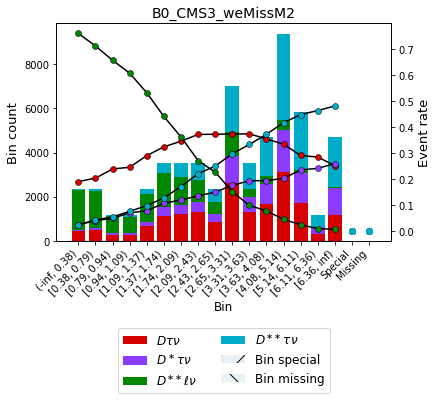

In [55]:
binning_table.plot(show_bin_labels=True)

In [40]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Multiclass Binning Table Analysis
-------------------------------------------------

  General metrics

    JS (Jensen-Shannon)      0.19093966
    HHI                      0.09283523
    HHI (normalized)         0.02305332
    Cramer's V               0.33970402
    Quality score            0.52765047

  Monotonic trend

    Class  0                       peak
    Class  1                  ascending
    Class  2                 descending
    Class  3                  ascending

  Significance tests

    Bin A  Bin B  t-statistic      p-value
        0      1    94.623105 2.224906e-20
        1      2   186.760108 3.058066e-40
        2      3    88.644009 4.283332e-19
        3      4    37.704862 3.263800e-08
        4      5    85.170222 2.385709e-18
        5      6   126.548790 2.997371e-27
        6      7    66.894189 1.972869e-14
        7      8    43.805453 1.659838e-09
        8      9    52.454025 2.396832e-

## p_D + p_ell

In [79]:
variable = "p_D_l"
x = combined_df[variable]
y = combined_df['label']

optb = MulticlassOptimalBinning(name=variable, solver="cp",
                                monotonic_trend='auto',
                                max_n_prebins=50, min_n_bins=1, max_n_bins=50,
                                prebinning_method='quantile',time_limit=10000,verbose=True)
optb.fit(x, y)

2025-03-28 07:52:33,325 | INFO : Optimal binning started.
2025-03-28 07:52:33,325 | INFO : Options: check parameters.
2025-03-28 07:52:33,326 | INFO : Pre-processing started.
2025-03-28 07:52:33,326 | INFO : Pre-processing: number of samples: 12196
2025-03-28 07:52:33,327 | INFO : Pre-processing: number of clean samples: 12196
2025-03-28 07:52:33,327 | INFO : Pre-processing: number of missing samples: 0
2025-03-28 07:52:33,327 | INFO : Pre-processing: number of special samples: 0
2025-03-28 07:52:33,327 | INFO : Pre-processing terminated. Time: 0.0007s
2025-03-28 07:52:33,328 | INFO : Pre-binning started.
2025-03-28 07:52:33,335 | INFO : Pre-binning: number prebins removed: 2
2025-03-28 07:52:33,339 | INFO : Pre-binning: number prebins removed: 1
2025-03-28 07:52:33,341 | INFO : Pre-binning: number of prebins: 48
2025-03-28 07:52:33,342 | INFO : Pre-binning: number of refinements: 2
2025-03-28 07:52:33,342 | INFO : Pre-binning terminated. Time: 0.0135s
2025-03-28 07:52:33,342 | INFO : 

MulticlassOptimalBinning(max_n_bins=50, max_n_prebins=50, min_n_bins=1,
                         name='p_D_l', prebinning_method='quantile',
                         time_limit=10000, verbose=True)

In [80]:
optb.splits

array([1.92877936, 2.02378788, 2.14099231, 2.52898073, 2.88652382,
       3.00518017, 3.14624252, 3.24071815])

In [81]:
np.diff(optb.splits)

array([0.09500852, 0.11720443, 0.38798842, 0.35754309, 0.11865635,
       0.14106236, 0.09447563])